In [1]:
!pip install --upgrade segmentation-models-3D

  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires keras>=3.5.0, but you have keras 3.3.3 which is incompatible.


In [2]:
""" 
3D Model U Net

"""

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 128, 128, 128, 16) │           1,312 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128, 128, 128, 16) │               0 │ conv3d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 128, 128, 128, 16) │           6,928 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 64, 64, 64, 16)    │               0 │ conv3d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64, 64, 64, 32)    │               0 │ conv3d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 32, 32, 32, 32)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32, 32, 32, 64)    │               0 │ conv3d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 16, 16, 16, 64)    │               0 │ conv3d_5[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 16, 16, 16, 128)   │               0 │ conv3d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 16, 16, 16, 128)   │         442,496 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [57]:
# def load_img(img_dir, img_list):
#     images = []
#     for i, image_name in enumerate(img_list):    
#         if (image_name.split('.')[1] == 'npy'):
#             image = np.load(img_dir + image_name).astype(np.float32)  # Ensure float32
#             images.append(image)
#     images = np.array(images)
#     return images

# def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
#     L = len(img_list)
#     while True:
#         batch_start = 0
#         batch_end = batch_size
#         while batch_start < L:
#             limit = min(batch_end, L)
#             X = load_img(img_dir, img_list[batch_start:limit])
#             Y = load_img(mask_dir, mask_list[batch_start:limit]).astype(np.float32)  # Ensure float32
#             yield (X, Y)
#             batch_start += batch_size   
#             batch_end += batch_size


In [16]:
def load_img(img_dir, img_list):
    images = []
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir + image_name).astype(np.float32)  # Ensure float32
            images.append(image)
    images = np.array(images)
    return images

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit]).astype(np.float32)  # Ensure float32
            yield (X, Y)
            batch_start += batch_size   
            batch_end += batch_size


In [5]:
"""
Convert BRATS 2020 dataset ready for semantic segmentation. 
Code can be divided into a few parts....

#Combine 
#Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)
#Visualize


All BraTS multimodal scans are available as NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

"""


import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
##########################
#This part of the code to get an initial understanding of the dataset.
#################################
#PART 1: Load sample images and visualize
#Includes, dividing each image by its max to scale them to [0,1]
#Converting mask from float to uint8
#Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)
#Visualize

In [6]:
# t2_list = sorted(glob.glob("C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii"))
# t1ce_list = sorted(glob.glob("C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii"))
# flair_list = sorted(glob.glob("C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii"))
# mask_list = sorted(glob.glob("C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii"))

# #Each volume generates 18 64x64x64x4 sub-volumes. 
# #Total 369 volumes = 6642 sub volumes

# for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
#     print("Now preparing image and masks number: ", img)
      
#     temp_image_t2=nib.load(t2_list[img]).get_fdata()
#     temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
#     temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
#     temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
#     temp_image_flair=nib.load(flair_list[img]).get_fdata()
#     temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
#     temp_mask=nib.load(mask_list[img]).get_fdata()
#     temp_mask=temp_mask.astype(np.uint8)
#     temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
#     #print(np.unique(temp_mask))
    
    
#     temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
#     #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#     #cropping x, y, and z
#     temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
#     temp_mask = temp_mask[56:184, 56:184, 13:141]
    
#     val, counts = np.unique(temp_mask, return_counts=True)
    
#     if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
#         print("Save Me")
#         temp_mask= to_categorical(temp_mask, num_classes=4)
#         np.save("C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/images/image_"+str(img)+'.npy', temp_combined_images)
#         np.save('C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/masks/mask_'+str(img)+'.npy', temp_mask)
        
#     else:
#         print("I am useless")   
   

In [5]:
!pip install split-folders

In [7]:
# ################################################################
# #Repeat the same from above for validation data folder OR
# #Split training data into train and validation

# """
# Code for splitting folder into train, test, and val.
# Once the new folders are created rename them and arrange in the format below to be used
# for semantic segmentation using data generators. 
# """
# import splitfolders  # or import split_folders

# input_folder = 'C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/'
# output_folder = 'C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/validation_numpy'
# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
# ########################################

In [8]:
# CUSTOM_DATAGEN

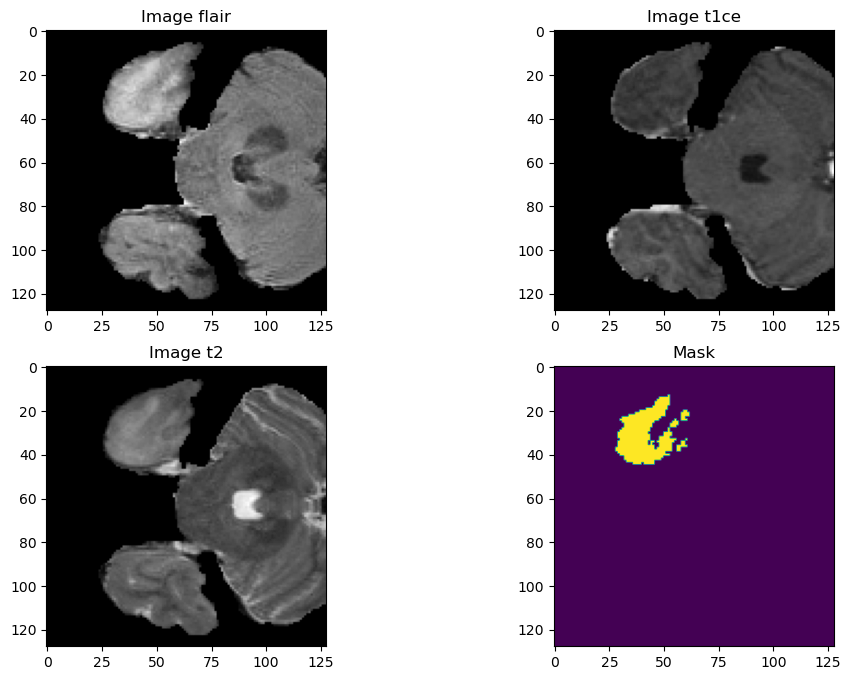

In [9]:

import os
import numpy as np
from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random


Image_shape : (2, 128, 128, 128, 3)
Mask_shape : (2, 128, 128, 128, 4)


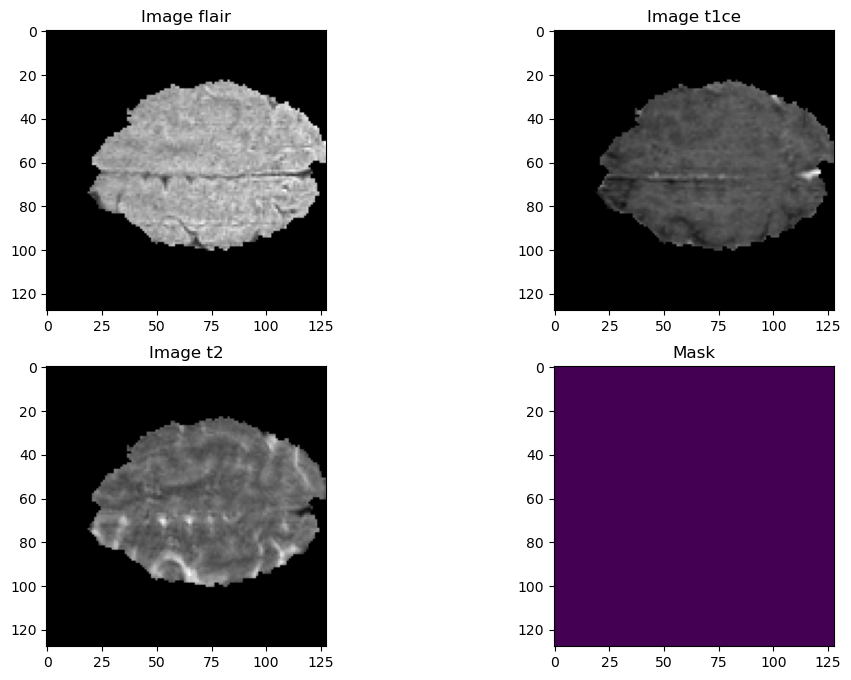

In [10]:
#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/images/"
train_mask_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

print("Image_shape :", img.shape)
print("Mask_shape :",msk.shape)


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [11]:
"""Code to train batches of cropped BraTS 2020 images using 3D U-net.

Please get the data ready and define custom data gnerator using the other
files in this directory.

Images are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for 
                                                  test_image_flair, test_image_t1ce, test_image_t2)
Change the U-net input shape based on your input dataset shape (e.g. if you decide to only se 2 channels or all 4 channels)

Masks are expected to be 128x128x128x3 npy data (4 corresponds to the 4 classes / labels)


You can change input image sizes to customize for your computing resources.
"""


import os
import numpy as np
from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

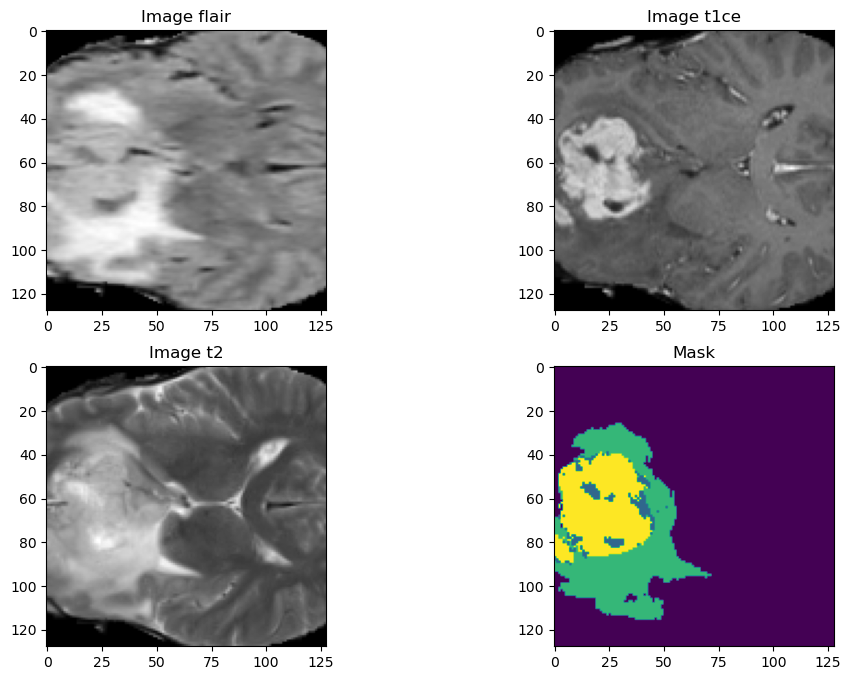

In [21]:

####################################################
train_img_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/images/"
train_mask_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

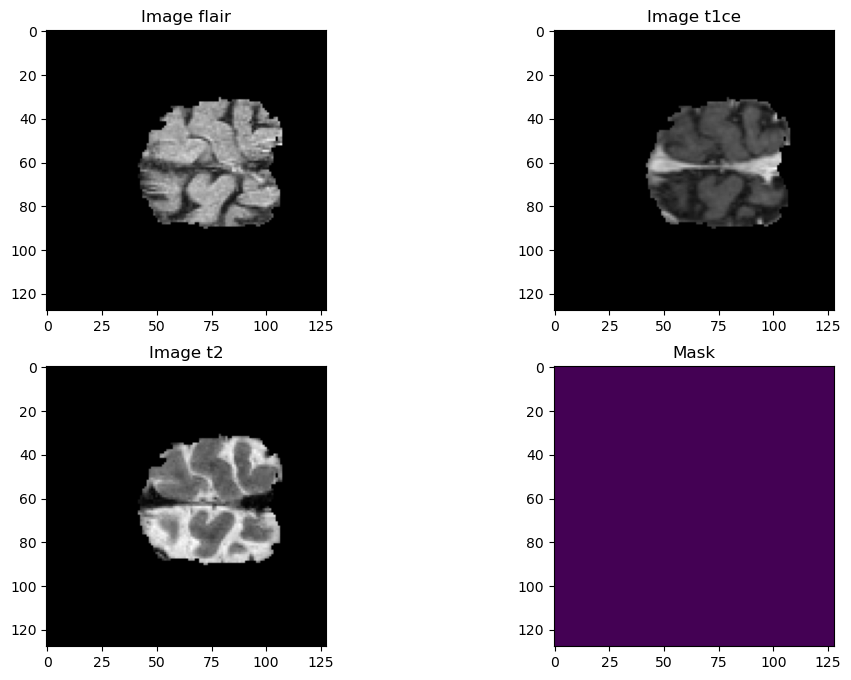

In [22]:
##############################################################
#Define the image generators for training and validation

train_img_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/images/"
train_mask_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/Training_numpy/masks/"

val_img_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/validation_numpy/images/"
val_mask_dir = "C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/validation_numpy/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [23]:
from keras.metrics import MeanIoU
###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# metrics = ['accuracy', IOUScoreWithCast(threshold=0.5)]
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]


# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
#######################################################################

Segmentation Models: using `keras` framework.


In [24]:
#######################################################################
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_57 (Conv3D)            │ (None, 128, 128, 128, 16) │           1,312 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_27 (Dropout)          │ (None, 128, 128, 128, 16) │               0 │ conv3d_57[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_58 (Conv3D)            │ (None, 128, 128, 128, 16) │           6,928 │ dropout_27[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_12              │ (None, 64, 64, 64, 16)    │               0 │ conv3d_58[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_59 (Conv3D)            │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_28 (Dropout)          │ (None, 64, 64, 64, 32)    │               0 │ conv3d_59[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_60 (Conv3D)            │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_28[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_13              │ (None, 32, 32, 32, 32)    │               0 │ conv3d_60[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_61 (Conv3D)            │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_13[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_29 (Dropout)          │ (None, 32, 32, 32, 64)    │               0 │ conv3d_61[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_62 (Conv3D)            │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_29[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_14              │ (None, 16, 16, 16, 64)    │               0 │ conv3d_62[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_63 (Conv3D)            │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_30 (Dropout)          │ (None, 16, 16, 16, 128)   │               0 │ conv3d_63[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_64 (Conv3D)            │ (None, 16, 16, 16, 128)   │         442,49

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_57 (Conv3D)            │ (None, 128, 128, 128, 16) │           1,312 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_27 (Dropout)          │ (None, 128, 128, 128, 16) │               0 │ conv3d_57[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_58 (Conv3D)            │ (None, 128, 128, 128, 16) │           6,928 │ dropout_27[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_12              │ (None, 64, 64, 64, 16)    │               0 │ conv3d_58[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_59 (Conv3D)            │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_28 (Dropout)          │ (None, 64, 64, 64, 32)    │               0 │ conv3d_59[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_60 (Conv3D)            │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_28[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_13              │ (None, 32, 32, 32, 32)    │               0 │ conv3d_60[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_61 (Conv3D)            │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_13[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_29 (Dropout)          │ (None, 32, 32, 32, 64)    │               0 │ conv3d_61[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_62 (Conv3D)            │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_29[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_14              │ (None, 16, 16, 16, 64)    │               0 │ conv3d_62[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_63 (Conv3D)            │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_30 (Dropout)          │ (None, 16, 16, 16, 128)   │               0 │ conv3d_63[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_64 (Conv3D)            │ (None, 16, 16, 16, 128)   │         442,49

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


Image data type: float32
Mask data type: float32
Image shape: (2, 128, 128, 128, 3)
Mask shape: (2, 128, 128, 128, 4)
Mask data type after casting to float32: float32


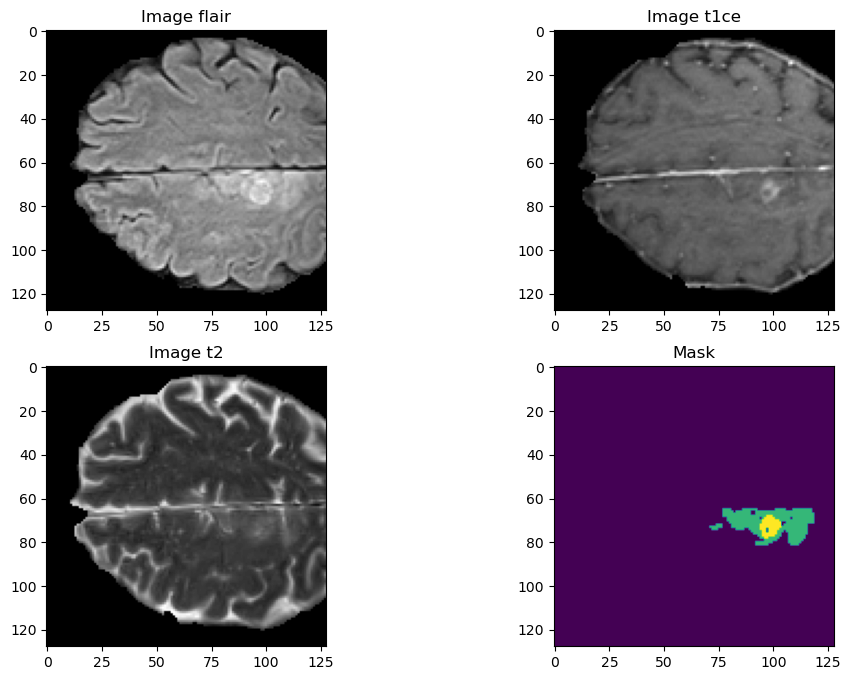

In [25]:
# Get a batch of images and masks
img, msk = train_img_datagen.__next__()

# Print data types of the image and mask
print("Image data type:", img.dtype)
print("Mask data type:", msk.dtype)

# Optionally, you can also print the shapes to check
print("Image shape:", img.shape)
print("Mask shape:", msk.shape)

# Check if the mask is in float32
msk = msk.astype(np.float32)

# Now you can print again to verify the conversion (just for debugging purposes)
print("Mask data type after casting to float32:", msk.dtype)

# Optionally, you can visualize a slice to ensure it looks correct
img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')
plt.show()


In [26]:
# Get a batch of images and masks
img, msk = train_img_datagen.__next__()

# Ensure both image and mask are float32
img = img.astype(np.float32)
msk = msk.astype(np.float32)

# Print data types of the image and mask
print("Image data type:", img.dtype)
print("Mask data type:", msk.dtype)

# Optionally, check the shape
print("Image shape:", img.shape)
print("Mask shape:", msk.shape)


Image data type: float32
Mask data type: float32
Image shape: (2, 128, 128, 128, 3)
Mask shape: (2, 128, 128, 128, 4)


In [48]:
##################################################################
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

##################################################################

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 4674s 36s/step - accuracy: 0.9893 - iou_score: 0.7960 - loss: 0.7841 - val_accuracy: 0.9789 - val_iou_score: 0.6223 - val_loss: 0.8296
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1758s 14s/step - accuracy: 0.9893 - iou_score: 0.7946 - loss: 0.7843 - val_accuracy: 0.9797 - val_iou_score: 0.6342 - val_loss: 0.8242
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1764s 14s/step - accuracy: 0.9897 - iou_score: 0.7997 - loss: 0.7833 - val_accuracy: 0.9806 - val_iou_score: 0.6489 - val_loss: 0.8204
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1754s 14s/step - accuracy: 0.9901 - iou_score: 0.8032 - loss: 0.7826 - val_accuracy: 0.9806 - val_iou_score: 0.6439 - val_loss: 0.8214
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1769s 14s/step - accuracy: 0.9901 - iou_score: 0.8014 - loss: 0.7829 - val_accuracy: 0.9800 - val_iou_score: 0.6328 - val_loss: 0.8236
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1766s 14s/step - accuracy: 0.9902 - iou_score: 0.8023 - loss: 0.7827 - val_accuracy: 

In [49]:
model.save('C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/brats_30_epochs.hdf5')

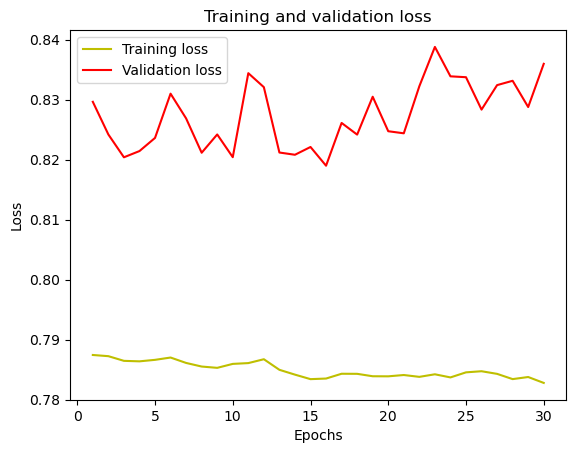

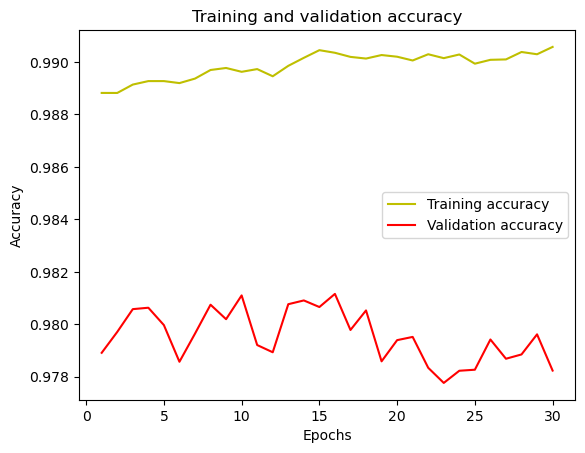

In [50]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#################################################

In [ ]:
# import matplotlib.pyplot as plt

# # Define save path
# save_path = r"C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/"

# # Plot and save loss graph
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)

# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig(save_path + "training_validation_loss.png")  # Save the figure
# plt.show()

# # Plot and save accuracy (IoU) graph
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.savefig(save_path + "training_validation_accuracy.png")  # Save the figure
# plt.show()


In [ ]:
# #################################################
# from keras.models import load_model

# #Load model for prediction or continue training

# #For continuing training....
# #The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
# #This is because the model does not save loss function and metrics. So to compile and 
# #continue training we need to provide these as custom_objects.
# my_model = load_model('C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/brats_only_1.hdf5')

# #So let us add the loss as custom object... but the following throws another error...
# #Unknown metric function: iou_score
# my_model = load_model('C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/brats_only_1.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss})

# #Now, let us add the iou_score function we used during our initial training
# my_model = load_model('C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/brats_only_1.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})

# #Now all set to continue the training process. 
# history2=my_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=1,
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )
# #################################################

In [64]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ------ --------------------------------- 6.0/39.5 MB 30.8 MB/s eta 0:00:02
   -------------- ------------------------- 14.7/39.5 MB 36.9 MB/s eta 0:00:01
   ----------------------- ---------------- 23.3/39.5 MB 38.8 MB/s eta 0:00:01
   -------------------------------- ------- 31.7/39.5 MB 39.5 MB/s eta 0:00:01
   ---------------------------------------  39.1/39.5 MB 38.8 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 31.8 MB/s eta 0:00:00


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Mean IoU: 0.7624
Accuracy: 99.25%


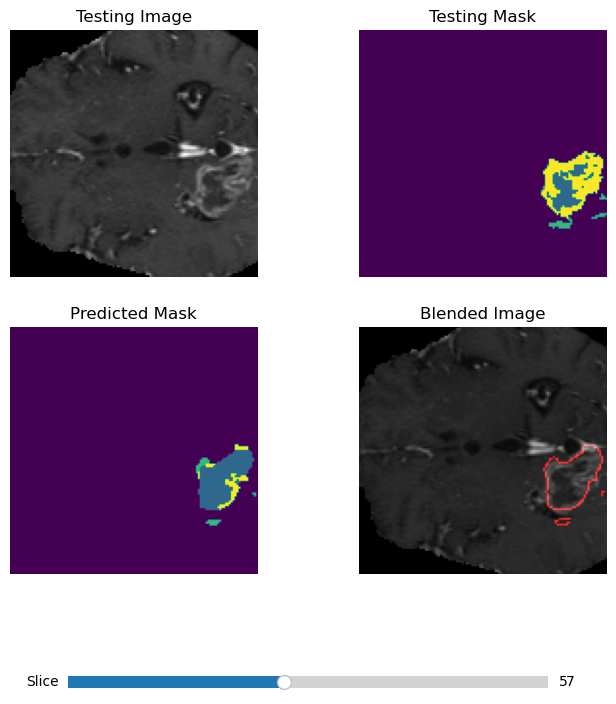

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.metrics import MeanIoU
from matplotlib.widgets import Slider
import matplotlib.animation as animation

# Load trained model (No need to compile for inference)
my_model = load_model('C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/brats_30_epochs.hdf5', compile=False)

# Load test image and mask
img_num = 41
test_img = np.load(f"C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/validation_numpy/images/image_{img_num}.npy")
test_mask = np.load(f"C:/Users/BharathKumar/Desktop/Final_Tumor_seg_Project/validation_numpy/masks/mask_{img_num}.npy")

# Convert ground truth mask to categorical labels
test_mask_argmax = np.argmax(test_mask, axis=3)

# Make prediction
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0, :, :, :]

# Compute IoU
n_classes = 4
iou_metric = MeanIoU(num_classes=n_classes)
iou_metric.update_state(test_prediction_argmax, test_mask_argmax)
iou_score = iou_metric.result().numpy()

# Compute accuracy
accuracy = np.mean(test_prediction_argmax == test_mask_argmax)

# Print IoU and Accuracy
print(f"Mean IoU: {iou_score:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Initialize figure and axis
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.2)

# Select a random initial slice
n_slices = test_img.shape[2]
initial_slice = np.random.randint(0, n_slices)

# Function to update the visualization based on the slice number
def update(n_slice):
    n_slice = int(n_slice)

    # Normalize MRI scan for visualization
    test_img_norm = (test_img[:, :, n_slice, 1] - np.min(test_img[:, :, n_slice, 1])) / \
                    (np.max(test_img[:, :, n_slice, 1]) - np.min(test_img[:, :, n_slice, 1]))
    test_img_rgb = cv2.cvtColor((test_img_norm * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Convert predicted mask to uint8 and apply colormap
    pred_mask_uint8 = np.uint8(np.clip(test_prediction_argmax[:, :, n_slice], 0, 1) * 255)
    pred_mask_colored = cv2.applyColorMap(pred_mask_uint8, cv2.COLORMAP_JET)

    # Detect tumor border using Canny edge detection
    mask_edges = cv2.Canny(pred_mask_uint8, threshold1=100, threshold2=200)

    # Convert edges to a red border
    mask_edges_colored = np.zeros_like(test_img_rgb)  # Blank RGB image
    mask_edges_colored[mask_edges > 0] = [255, 0, 0]  # Set edges to red (BGR format)

    # Blend the MRI image with red tumor border
    blended_with_edges = cv2.addWeighted(test_img_rgb, 0.7, mask_edges_colored, 0.8, 0)

    # Update plots
    ax[0, 0].cla()
    ax[0, 0].set_title('Testing Image')
    ax[0, 0].imshow(test_img[:, :, n_slice, 1], cmap='gray')
    ax[0, 0].axis('off')

    ax[0, 1].cla()
    ax[0, 1].set_title('Testing Mask')
    ax[0, 1].imshow(test_mask_argmax[:, :, n_slice])
    ax[0, 1].axis('off')

    ax[1, 0].cla()
    ax[1, 0].set_title('Predicted Mask')
    ax[1, 0].imshow(test_prediction_argmax[:, :, n_slice])
    ax[1, 0].axis('off')

    ax[1, 1].cla()
    ax[1, 1].set_title('Blended Image')
    ax[1, 1].imshow(blended_with_edges)
    ax[1, 1].axis('off')

    fig.canvas.draw_idle()

# Initial plot setup
update(initial_slice)

# Create a slider
ax_slider = plt.axes([0.2, 0.05, 0.6, 0.03])
slice_slider = Slider(ax_slider, 'Slice', 0, n_slices - 1, valinit=initial_slice, valstep=1)
slice_slider.on_changed(update)

# Function to animate the slider
def animate(i):
    new_slice = int(i % n_slices)  # Loop through slices
    slice_slider.set_val(new_slice)  # Update slider value

# Create animation (adjust interval for speed)
ani = animation.FuncAnimation(fig, animate, frames=n_slices, interval=300, repeat=True)

plt.show()
